### Combined analysis of RNA-seq and ATAC-seq in MEF and EB

In [7]:
library(GenomicRanges)
library(ChIPpeakAnno)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(BSgenome.Mmusculus.UCSC.mm10)
library(org.Mm.eg.db)
library(clusterProfiler)
library(gplots)
library(dplyr)
library(EnrichedHeatmap)
library(circlize)
library(VennDiagram)

In [5]:
# A combined Etv2 ChIP-seq peak set (EB and MEF)
all_etv2_peaks_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'
gr <- readRDS(gzcon(url(all_etv2_peaks_url)))
gr
colnames(gr$group)

GRanges object with 162010 ranges and 4 metadata columns:
           seqnames            ranges strand |
              <Rle>         <IRanges>  <Rle> |
       [1]     chr1   3037784-3037983      * |
       [2]     chr1   3263790-3263989      * |
       [3]     chr1   3344682-3344881      * |
       [4]     chr1   3460640-3460839      * |
       [5]     chr1   3490314-3490513      * |
       ...      ...               ...    ... .
  [162006]     chrY 90828936-90829135      * |
  [162007]     chrY 90836259-90836458      * |
  [162008]     chrY 90841624-90841823      * |
  [162009]     chrY 90842563-90842762      * |
  [162010]     chrY 90843810-90844009      * |
                                                                                                                 peak_id
                                                                                                             <character>
       [1]      /panfs/roc/scratch/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=2

[1] "MEF_Dox_d1_Etv2" "MEF_Dox_d2_Etv2" "MEF_Dox_d7_Etv2" "EB_Dox_3h_Etv2" 
[5] "EB_Dox_12h_Etv2"

In [34]:
n_MEF_peaks <- sum(gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d2_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2'])
cat(sprintf('total number of Etv2 peaks in MEF: %d\n', n_MEF_peaks))
n_EB_peaks <- sum(gr$group[, 'EB_Dox_3h_Etv2'] | gr$group[, 'EB_Dox_12h_Etv2'])
cat(sprintf('total number of Etv2 peaks in MEF: %d\n', n_EB_peaks))
cat(sprintf('day 1 peaks in all MEF peaks: %%%.3f\n', 100 * sum(gr$group[, 'MEF_Dox_d1_Etv2']) / n_MEF_peaks))
cat(sprintf('3h peaks in all EB peaks: %%%.3f\n', 100 * sum(gr$group[, 'EB_Dox_3h_Etv2']) / n_EB_peaks))


total number of Etv2 peaks in MEF: 154468
total number of Etv2 peaks in MEF: 19651
day 1 peaks in all MEF peaks: %79.846
3h peaks in all EB peaks: %82.922


(polygon[GRID.polygon.143], polygon[GRID.polygon.144], polygon[GRID.polygon.145], polygon[GRID.polygon.146], polygon[GRID.polygon.147], polygon[GRID.polygon.148], text[GRID.text.149], text[GRID.text.150], text[GRID.text.151], text[GRID.text.152], text[GRID.text.153], text[GRID.text.154], text[GRID.text.155], text[GRID.text.156], text[GRID.text.157], text[GRID.text.158]) 

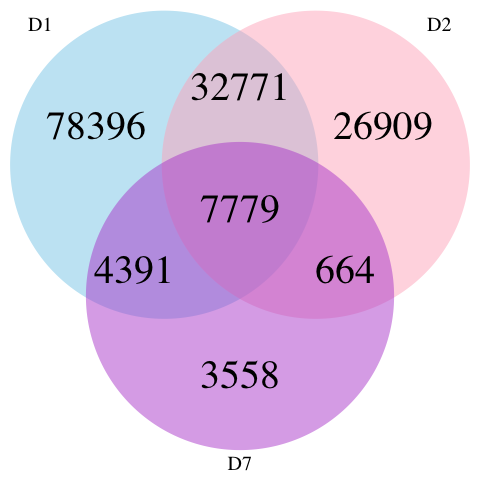

In [19]:
# Venn diagram of Etv2 ChIP-seq peaks distributed in MEF and EB
options(repr.plot.width=4, repr.plot.height=4)
draw.triple.venn(
  area1 = sum(gr$group[, 'MEF_Dox_d1_Etv2']),
  area2 = sum(gr$group[, 'MEF_Dox_d2_Etv2']), 
  area3 = sum(gr$group[, 'MEF_Dox_d7_Etv2']), 
  n12 = sum(gr$group[, 'MEF_Dox_d1_Etv2'] & gr$group[, 'MEF_Dox_d2_Etv2']), 
  n23 = sum(gr$group[, 'MEF_Dox_d2_Etv2'] & gr$group[, 'MEF_Dox_d7_Etv2']), 
  n13 = sum(gr$group[, 'MEF_Dox_d1_Etv2'] & gr$group[, 'MEF_Dox_d7_Etv2']), 
  n123 = sum(gr$group[, 'MEF_Dox_d1_Etv2'] & gr$group[, 'MEF_Dox_d2_Etv2'] & gr$group[, 'MEF_Dox_d7_Etv2']),
  category = c("D1", "D2", "D7"), 
  lty = "blank", 
  fill = c("skyblue", "pink1", "mediumorchid"),
  cex = 2,
  cat.cex = 1
)

(polygon[GRID.polygon.168], polygon[GRID.polygon.169], polygon[GRID.polygon.170], polygon[GRID.polygon.171], text[GRID.text.172], text[GRID.text.173], text[GRID.text.174], text[GRID.text.175], text[GRID.text.176]) 

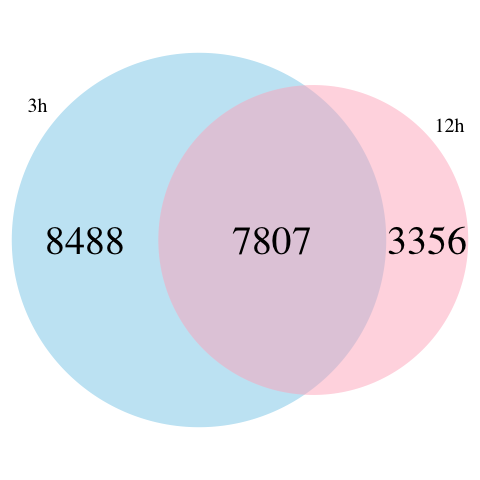

In [21]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(gr$group[, 'EB_Dox_3h_Etv2']),
  area2 = sum(gr$group[, 'EB_Dox_12h_Etv2']), 
  cross.area = sum(gr$group[, 'EB_Dox_3h_Etv2'] & gr$group[, 'EB_Dox_12h_Etv2']), 
  category = c("3h", '12h'), 
  lty = "blank", 
  fill = c("skyblue", "pink1"),
  cex = 2,
  cat.cex = 1
)

In [ ]:
# split the Etv2 MEF D1 peaks into three groups:
# 1. on at D1 and off at D7 (early)
# 2. off at D1 and on at D7 (late)
# 3. on at both D1 and D7 (persist)
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]